# **Final Project:** Exploring Customer Feedback for Strategic Insights on Amazon Review Dataset
*   This notebook explore the amazon review dataset(https://amazon-reviews-2023.github.io/) and predict product feature like avg_rating & product popularity

## **Product Popularity Analysis**

### Step 1: Installing necessary libraries

#### Installing **dask**

In [ ]:
!pip install dask
!pip install dask[dataframe]
!pip install dask-ml
!pip install dask-ml[complete]

### Step 2: Saving data to parquet files

In [ ]:
# File paths
files = {
    'df1': '/content/drive/MyDrive/Colab Notebooks/Project/All_Beauty.jsonl',
    'df2': '/content/drive/MyDrive/Colab Notebooks/Project/meta_All_Beauty.jsonl',
    'df3': '/content/drive/MyDrive/Colab Notebooks/Project/Beauty_and_Personal_Care.jsonl',
    'df4': '/content/drive/MyDrive/Colab Notebooks/Project/meta_Beauty_and_Personal_Care.jsonl'
}

In [ ]:
# 1. Converting JSONL files to Parquet
for key, filepath in files.items():
    ddf = dd.read_json(filepath, lines=True, blocksize='64MB')
    parquet_path = filepath.replace('.jsonl', '_parquet')
    ddf.to_parquet(parquet_path, engine='pyarrow', write_index=False)

### Step 3: Reading **datasets** from parquet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import dask.dataframe as dd

In [ ]:
df1 = dd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Project/All_Beauty_parquet')

In [ ]:
df2 = dd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Project/meta_All_Beauty_parquet')

In [ ]:
df3 = dd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Project/Beauty_and_Personal_Care_parquet')

In [ ]:
df4 = dd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Project/meta_Beauty_and_Personal_Care_parquet')

##### Merging Item and Meta files for allBeauty and Beauty & Personal Care data

In [ ]:
df_allBeautyFull = dd.merge(df1,df2,on='parent_asin',how='left')

In [ ]:
df_pcFull = dd.merge(df3,df4,on='parent_asin',how='left')

##### Getting only 700k rows from allBeauty(item+meta) dataset and concatenating both the datasets

In [ ]:
num = 700_000/701_528
df_allBeautyFull7 = df_allBeautyFull.sample(frac=num,random_state=42)

In [ ]:
df_full = dd.concat([df_allBeautyFull,df_pcFull])

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/Project/output_parquet/'

# Write the DataFrame to Parquet
df_full.to_parquet(output_path, write_index=False)

### Step 4: EDA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#### 1. Identifying Worst and Best Performing Products using custom product score column

In [ ]:
# Converting verified_purchase column to float, so that it can be used to calculate product score column
df_full['verified_purchase'] = df_full['verified_purchase'].astype(float)

gr_product = df_full.groupby("asin").agg({
    "rating": ["mean","count"],
    "helpful_vote": "sum",
    "verified_purchase": "mean"
}).reset_index()

In [ ]:
# renaming columns
gr_product.columns = ["asin","avg_rating", "rating_count", "total_helpful_votes", "verified_purchase"]

In [ ]:
# Calculating product score
gr_product["product_score"] = (
    gr_product["avg_rating"] * 0.5 +
    np.log1p(gr_product["rating_count"]) * 0.3 +
    np.log1p(gr_product["total_helpful_votes"]) * 0.15 +
    gr_product["verified_purchase"] * 0.05
)

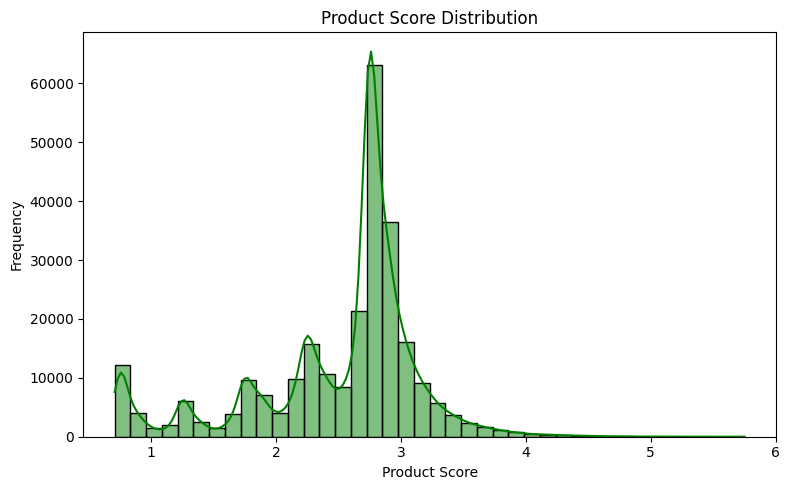

In [ ]:
# plotting the product score distribution
np.random.seed(42)
df_pd = gr_product.compute()
scores = df_pd['product_score']

plt.figure(figsize=(8, 5))
sns.histplot(scores, bins=40, kde=True, color="green")
plt.title("Product Score Distribution")
plt.xlabel("Product Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
#merging product score with the main dataframe
dff = df_full.merge(gr_product[['asin', 'product_score']], on='asin', how='left')

In [ ]:
best_selling = df_pd.sort_values('product_score',ascending=False).head(10) # Top 10 Best Selling Products
worst_selling = df_pd.sort_values('product_score',ascending=True).head(10) # Top 10 Worst Selling Products

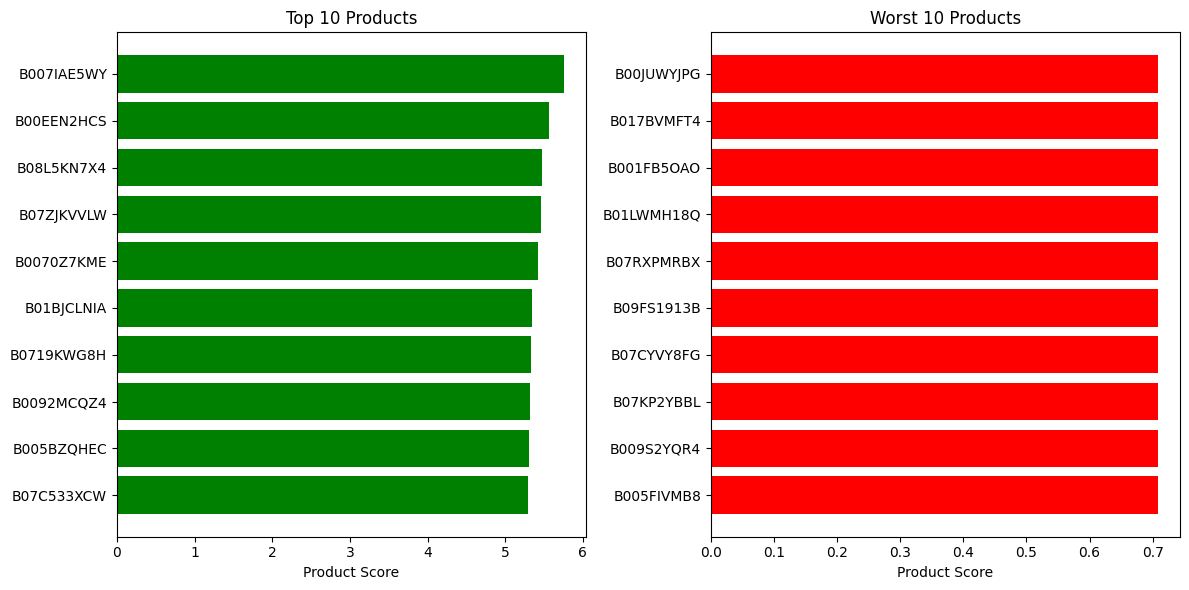

In [ ]:
plt.figure(figsize=(12, 6))

# Plot Top 10
plt.subplot(1, 2, 1)
plt.barh(best_selling['asin'], best_selling['product_score'], color='green')
plt.title("Top 10 Products")
plt.xlabel("Product Score")
plt.gca().invert_yaxis()  # highest score at top

# Plot Worst 10
plt.subplot(1, 2, 2)
plt.barh(worst_selling['asin'], worst_selling['product_score'], color='red')
plt.title("Worst 10 Products")
plt.xlabel("Product Score")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


#### 2. Top 10 verified vs non-verified purchases

In [ ]:
# Get top 10 verified and unverified products
verified_top = df_full[df_full['verified_purchase']==1.0].groupby(['verified_purchase','asin'])['asin'].count().nlargest(10).compute().reset_index(name='count')
unverified_top = df_full[df_full['verified_purchase']==0.0].groupby(['verified_purchase','asin'])['asin'].count().nlargest(10).compute().reset_index(name='count')

# concatenating these into single dataframe
df_top10Prod = pd.concat([verified_top,unverified_top])

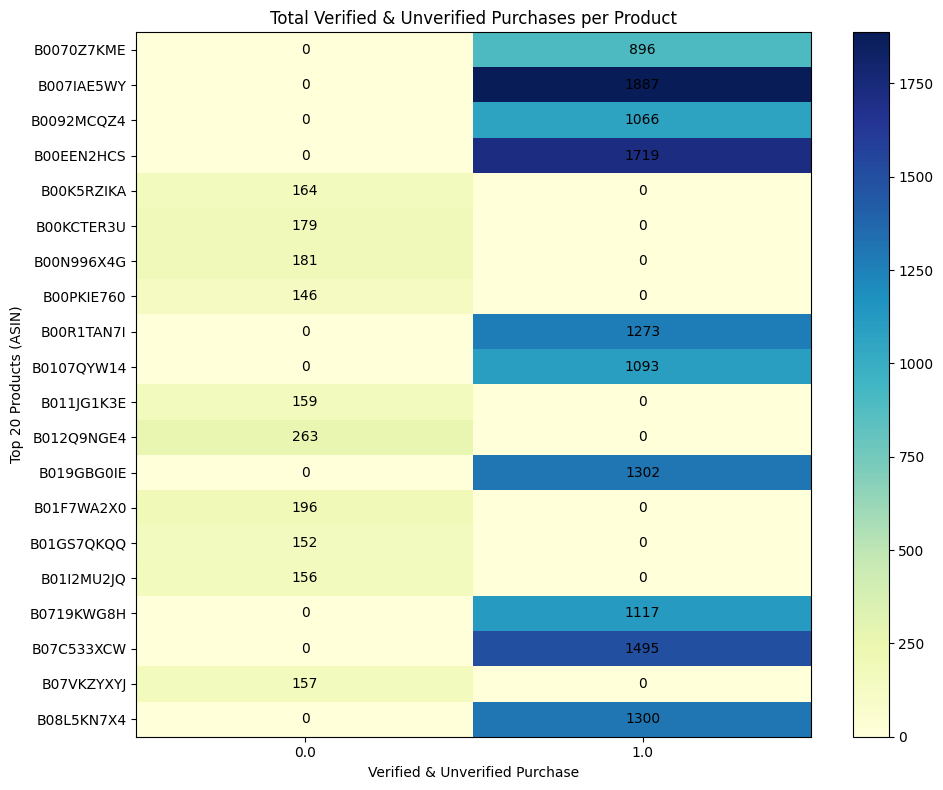

In [ ]:
# plotting heatmap for these top 10 verified and unverified products
heatmap_data = df_top10Prod.pivot(index='asin', columns='verified_purchase', values='count').fillna(0)
data = heatmap_data.values
x_labels = heatmap_data.columns.tolist()
y_labels = heatmap_data.index.tolist()

fig, ax = plt.subplots(figsize=(10, 8))

cax = ax.imshow(data, cmap='YlGnBu', aspect='auto')

ax.set_xticks(np.arange(len(x_labels)))
ax.set_yticks(np.arange(len(y_labels)))

# Label them
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)

# Annotate each cell with the numeric value
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, int(data[i, j]), ha='center', va='center', color='black')

plt.title("Total Verified & Unverified Purchases per Product")
plt.xlabel("Verified & Unverified Purchase")
plt.ylabel("Top 20 Products (ASIN)")

fig.colorbar(cax)

plt.tight_layout()
plt.show()


### Step 5: Data Preprocessing for Model **Predicton**

In [ ]:
# extracting data for feature column
dff['title_length'] = dff['title_x'].str.len()
dff['text_length'] = dff['text'].str.len()
dff['review_year'] = dff['timestamp'].dt.year
dff['review_month'] = dff['timestamp'].dt.month
dff['days_since_review'] = (pd.Timestamp.now().normalize() - dff['timestamp']).dt.days
dff['title_length'] = dff['title_length'].astype('int32')
dff['text_length'] = dff['text_length'].astype('int32')
dff['feature_length'] = dff['features'].str.len()
dff['description_length'] = dff['description'].str.len()

In [ ]:
dfClean = dff.drop(['rating', 'title_x', 'text', 'images_x', 'parent_asin','rating_number',
       'user_id', 'timestamp', 'helpful_vote', 'title_y', 'average_rating', 'author','store',
       'features', 'description', 'images_y', 'videos', 'bought_together','details','subtitle','categories'],axis=1)

In [ ]:
# Assigning product class(0,1,2) based on product score
def assign_product_class(score):
    if score > 4.5:
        return 2 # high
    elif score <= 4.5 and score >= 2.5:
        return 1 # medium
    else:
        return 0 # low

dfClean["product_class"] = dfClean['product_score'].apply(assign_product_class, meta=('product_class', 'int64'))

In [ ]:
dfClean['product_class'] = dfClean['product_class'].astype('int8')

In [ ]:
dfClean = dfClean[dfClean['price']>0]
dfClean = dfClean[dfClean['main_category']!='<NA>']

#### Balancing the dataset for model predictions

In [ ]:
min_size = 30000

# Filter by class and sample each to match the smallest class
low_df = dfClean[dfClean['product_class'] == 0].sample(frac=min_size/34209,random_state=42)
medium_df = dfClean[dfClean['product_class'] == 1].sample(frac=min_size / 211_565, random_state=42)
high_df = dfClean[dfClean['product_class'] == 2].sample(frac=min_size/40_000, random_state=42)

# Creating balanced df
balanced_df = dd.concat([low_df, medium_df, high_df])

In [ ]:
balanced_df.groupby('product_class')['product_class'].count().compute()

,product_class
product_class,
0,31689
1,31450
2,31487


### Step 6: Model prediction using RandomForestClassifier

In [ ]:
import dask
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
balanced_df = balanced_df.repartition(npartitions=10)

In [ ]:
# encoding the string column so as to include it in feature
balanced_df['main_category'] = balanced_df['main_category'].astype('category')
balanced_df['main_category'] = balanced_df['main_category'].cat.as_known()
balanced_df['main_category_encoded'] = balanced_df['main_category'].cat.codes

In [ ]:
# creating feature list
features = ["verified_purchase",
            "price",
            "title_length",
            "text_length",
            "review_year",
            "review_month",
            "days_since_review",
            "feature_length",
            "description_length",
            "main_category_encoded"
           ]

In [ ]:
balanced_df = balanced_df.persist()

In [ ]:
balanced_df_pd = balanced_df.compute()

In [ ]:
X = balanced_df_pd[features]
y = balanced_df_pd['product_class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7491281834513368
              precision    recall  f1-score   support

           0       0.64      0.69      0.66      6338
           1       0.65      0.59      0.62      6290
           2       0.95      0.97      0.96      6298

    accuracy                           0.75     18926
   macro avg       0.75      0.75      0.75     18926
weighted avg       0.75      0.75      0.75     18926



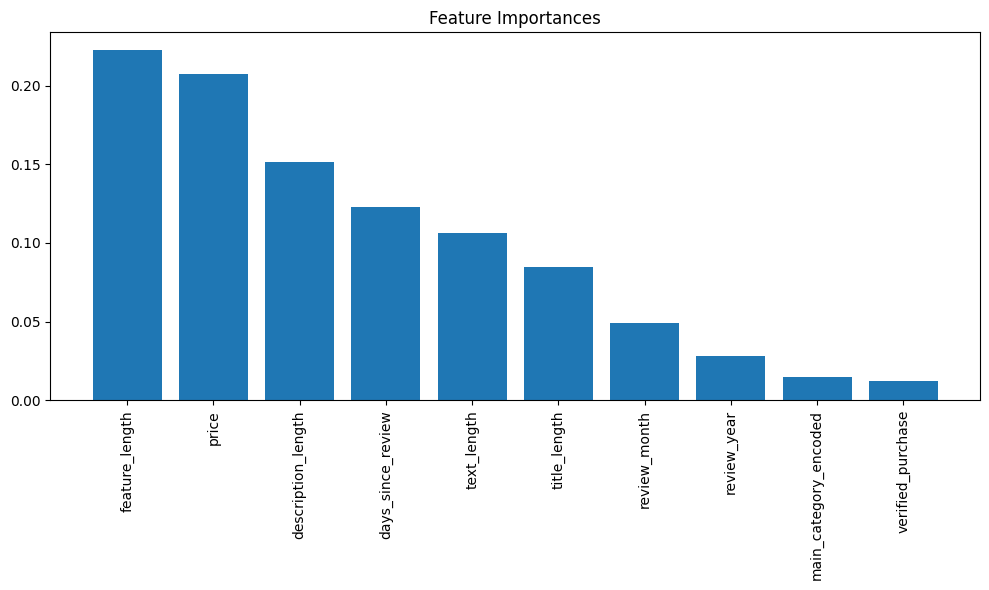

In [ ]:
# Get feature importances and feature names
importances = clf.feature_importances_
feature_names = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


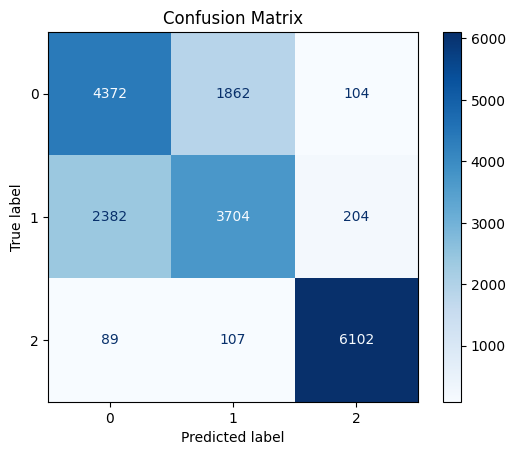

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

### Step 7: Model Improvement using XG Boost Model

In [ ]:
!pip install dask[complete] xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb

In [ ]:
from dask.distributed import Client
client = Client()

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:41919
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37659'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36433'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:45789 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45789
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:56164
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:37963 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:37963
INFO:distributed.core:Starting established connection to tcp://127

In [ ]:
X_xgb = balanced_df[features]
y_xgb = balanced_df['product_class']

In [ ]:
dtrain = xgb.dask.DaskDMatrix(client,X_xgb,y_xgb)
params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'num_class': 3
}

In [ ]:
# Train the model
output = xgb.dask.train(
    client,
    params,
    dtrain,
    num_boost_round=100,
)
booster = output['booster']

INFO:distributed.worker:Run out-of-band function '_start_tracker'


In [ ]:
y_preds_xgb = xgb.dask.predict(client, booster, X_xgb).compute()

In [ ]:
y_true_xgb = y_xgb.compute()

In [ ]:
acc_xgb = accuracy_score(y_true_xgb, y_preds_xgb)
print(f"Accuracy: {acc_xgb:.4f}")

Accuracy: 0.8040


              precision    recall  f1-score   support

           0       0.70      0.78      0.74     31689
           1       0.76      0.64      0.69     31450
           2       0.95      0.99      0.97     31487

    accuracy                           0.80     94626
   macro avg       0.80      0.80      0.80     94626
weighted avg       0.80      0.80      0.80     94626



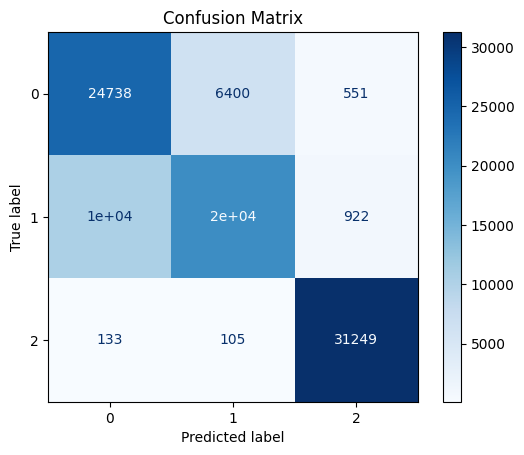

In [ ]:
print(classification_report(y_true_xgb, y_preds_xgb))

cm = confusion_matrix(y_true_xgb, y_preds_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Summary



1.  Length of the product features and price heavily decided on the predictions for product score.
2.  Main category and verified purchase did not affect the score predictions.
3.  With the RandomForestClassifier model and considering all numeric columns as features we observed the accuracy of 74.9% where model performed best for class 2 predictions while it perform moderately for class 0 and class 1.
4.  XG Booster model was applied for improvement which gave the improved accuracy of 80.4%.
5.  We can further enhance the accuracy by improving feature column and adding additional details like the text processing from the reviews column



